In [1]:
'''

    #### Time Series Modeling/Assessment ####

    Below code transforms historic nickel data to be used by various supervised learning regression algorithms to make price

    forecasts for one-year ahead of time. Predictor variables are created by taking lagged copies of itself and a target

    variable, y, which represents one year ahead of time, can be built by shifting all other X variables 

    back by one year (261 business days). 


    To compare performance with baseline models, the algorithms are also fit on data with one day ahead target variables.

    Predictions can be made for future dates using the final model that is selected.

'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from pylab import rcParams
rcParams['figure.figsize'] = 9, 6
import ast
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def LME_clean():
    '''Reads source file and cleans and reformats data as a time series in business days (B) as time units'''
    
    LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
    LME_futures = LME_futures.iloc[3:, 1:]
    LME_futures.columns = ['Date', 'Cash Price ($/MT)', 'Inventory (MT)']
    LME_futures.index = LME_futures['Date']
    LME_futures = LME_futures[LME_futures.index.year>=2005] # For now only use years after 2005

    LME_futures = LME_futures.iloc[:, 1:]

    LME = LME_futures.iloc[:, 0]
    LME = LME.astype(float)
    LME = LME.resample('B').mean()
    LME = LME.squeeze()
    return LME

def stationarity_preprocess(series, window_setting):
    '''
    Transforms Series data by taking difference of rolling average method for time series stationary. This 
    will allow us to build more effective predictive models.'''
    
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

def reverse_stationarity(series, train_tail, window_setting):
    '''
    Uses moving averages from the tail-end of training data 
    before using its own unscaled predictions to perform reverse differencing.
    '''
    unscaled = []
    for key, item in series.items():
        moving_avg = train_tail.tail(window_setting).mean()
        unscaled_result = item+moving_avg # reverse of differencing
        train_tail = train_tail.append(pd.Series([unscaled_result])) # Appends to tail-end of train_tail series before moving average is taken again
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled.index = series.index
    return unscaled


def time_series_train_test_split(df):

    X = df[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 
           ]]
    y= df['y']
    X_test = X.loc['2017-10-14':,:]
    y_test = y['2017-10-14':]
    X_train = X.loc[:'2017-10-14', :]
    y_train = y[:'2017-10-14']
    return X_train, X_test, y_train, y_test

def time_series_train_test_split_no_gap(df):

    X = df[['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 
           ]]
    y= df['lag0']
    X_test = X.loc['2017-10-14':,:]
    y_test = y['2017-10-14':]
    X_train = X.loc[:'2017-10-14', :]
    y_train = y[:'2017-10-14']
    return X_train, X_test, y_train, y_test


def minimum_mae(mae_results, model_name):
    
    '''Takes in dictionary of mae_results and parameter settings outputed from grid search
    and 1. calculates the optimal mae and associated parameter settings and 2. prints all mae results.'''
    
    key_min = min(mae_results.keys(), key=(lambda k: mae_results[k]))
    min_test_mae = mae_results[key_min]
    min_parameters = key_min

    print()
    print(str(model_name) + ' MAE Results by Parameter Setting:')
    for key, value in mae_results.items():
        print(key, value)
        
    print()
    print(str(model_name) + ' Minimum Test MAE: ', min_test_mae)
    print(str(model_name) + ' Best Parameters: ', min_parameters)

    return min_test_mae, min_parameters


def fit_predict(model, X_train, X_test, y_train, y_test, train_tail):
    '''
    1) Fits model on training data
    2) Makes predictions on test data
    3) Calls reverse_stationarity function 
    '''
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    y_pred_unscaled = reverse_stationarity(y_pred, train_tail, window_setting)
    y_unscaled = reverse_stationarity(y_test, train_tail, window_setting)
    
    y_pred_unscaled.index = y_pred_unscaled.index + pd.DateOffset(years=1)
    y_unscaled.index = y_unscaled.index + pd.DateOffset(years=1)
    
    return y_pred_unscaled, y_unscaled

import matplotlib.dates as mdates

def regression_plot(y_hat, y, model_name):
    #import seaborn as sns
    #plt.plot(y_hat)
    #plt.plot(y)
    
    #sns.set_style("darkgrid")
    locator = mdates.MonthLocator()  # every month
    # Specify the format - %b gives us Jan, Feb...
    fmt = mdates.DateFormatter('%b-%y')
    
    plt.plot(y_hat)
    plt.plot(y)
    
    X = plt.gca().xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    plt.xticks( rotation=45 )

    plt.legend(['y_hat', 'y'])
    plt.grid(linestyle="dashed")
    plt.title(model_name + ' Regression Prediction Results', fontsize=15)

    plt.show()
    
def preprocess_time_series(window_setting, lag_length):
    '''Calls all necessary preprocessing functions -  Prepares time series data for supervised learning experiments by creating additional lagged columns of the original
    column and assigning a target y variable by pushing all predictor X variables back by one year'''
    LME = LME_clean()    
    LME_shifted = LME.shift(-261).dropna()

    LME_stationary = stationarity_preprocess(LME, window_setting)
    df = pd.DataFrame(list(zip(list(LME_stationary.index), list(LME_stationary))), columns = ['ds', 'lag0'])
    
    for i in range(1, 11):
        lag_string = 'lag'+str(i)
        df[lag_string] = df.lag0.shift(periods=i*lag_length)

    df.index = df['ds']
    df = df.iloc[:, 1:]

    
    df['y'] = df['lag0'].shift(-261)
    df = df.dropna()
    return df, LME_shifted

def preprocess_time_series_same_day(window_setting, lag_length):
    '''Same as function above except assigning a target y variable of lag0, or same day, while other 
    predictor variables are taken from lagged copies of the original lag0'''
    LME = LME_clean()    
    LME_shifted = LME

    LME_stationary = stationarity_preprocess(LME, window_setting)
    df = pd.DataFrame(list(zip(list(LME_stationary.index), list(LME_stationary))), columns = ['ds', 'lag0'])
    
    for i in range(1, 11):
        lag_string = 'lag'+str(i)
        df[lag_string] = df.lag0.shift(periods=i*lag_length)

    df.index = df['ds']
    df = df.iloc[:, 1:]

    
    df['y'] = df['lag0']
    df = df.dropna()
    return df, LME_shifted

'''
The following functions 

    1) Fit models on training data/make predictions on test data
    2) Execute parameter tuning (depending on method used)
    2) Assess mean absolute errors (mae's) of multiple models and identifies/outputs highest performing model/set of parameters
    
'''


def run_linear_reg(X_train, X_test, y_train, y_test, train_tail):
    '''No parameter tuning for linear reg model'''

    # Model Fitting & Predictions
    regressor = LinearRegression()
    y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
    mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
    model_name = str(regressor).split('(')[0]
    print('Test Linear Regression MAE: ', mae)

    regression_plot(y_pred_unscaled, y_unscaled, model_name)

    min_test_mae = mae
    min_parameters = 'None'
    return min_test_mae, min_parameters, model_name



def run_polynomial(X_train, X_test, y_train, y_test, train_tail):
    '''Polynomial regression needs to be fitted manually, since it piggybacks off of linear regression model'''
    
    params1= range(2,5) # Evaluates different degrees of polynomial curve

    mae_results = {}

    for deg in params1:
        # Model Fitting & Predictions
        polynomial_features= PolynomialFeatures(degree=deg)

        X_poly = polynomial_features.fit_transform(X_train)

        regressor = LinearRegression()
        regressor.fit(X_poly, y_train)

        X_poly_test = polynomial_features.fit_transform(X_test)
        y_poly_pred = regressor.predict(X_poly_test)
        y_poly_pred = pd.Series(y_poly_pred)
        y_poly_pred.index = y_test.index
        
        y_pred_unscaled, y_unscaled = reverse_stationarity(y_poly_pred, train_tail, window_setting), reverse_stationarity(y_test, train_tail, window_setting)
        
        mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
        mae_results[str(deg)] = mae

    # To find the best/optimal parameters
    model_name = "Polynomial"
    min_test_mae, min_parameters = minimum_mae(mae_results, model_name) 
    min_parameters = ast.literal_eval(min_parameters)
    
    polynomial_features= PolynomialFeatures(degree=min_parameters)

    X_poly = polynomial_features.fit_transform(X_train)

    regressor = LinearRegression()
    regressor.fit(X_poly, y_train)

    X_poly_test = polynomial_features.fit_transform(X_test)
    y_poly_pred = regressor.predict(X_poly_test)
    y_poly_pred = pd.Series(y_poly_pred)
    y_poly_pred.index = y_test.index

    y_pred_unscaled, y_unscaled = reverse_stationarity(y_poly_pred, train_tail, window_setting), reverse_stationarity(y_test, train_tail, window_setting)
            
    regression_plot(y_pred_unscaled, y_unscaled, model_name)

    
    return min_test_mae, min_parameters, model_name


def run_lasso_grid(X_train, X_test, y_train, y_test, train_tail):
    
    params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                                })
    mae_results = {}

    for params in params1:
        # Model Fitting & Predictions
        regressor = linear_model.Lasso(**params, random_state=1)  
        y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
        mae_results[str(params)] = mae

    # To find the best/optimal parameters
    model_name = str(regressor).split('(')[0]
    min_test_mae, min_parameters = minimum_mae(mae_results, model_name) 
    min_parameters = ast.literal_eval(min_parameters) # Converts optimal parameters string to dict
    regressor = linear_model.Lasso(**min_parameters, random_state=1)

    y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        
    regression_plot(y_pred_unscaled, y_unscaled, model_name)

    
    return min_test_mae, min_parameters, model_name


def run_adaboost_grid(X_train, X_test, y_train, y_test, train_tail):
    '''Executes parameter tuning using grid search. 
    One final set of parameters is chosen and outputted with resulting MAE'''
    
    params1= ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250],
                            'learning_rate': [ .1, .01, .001, .0001]})

    mae_results = {}

    for params in params1:
        # Model Fitting & Predictions
        regressor = AdaBoostRegressor(**params, random_state=1)
        y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)

        mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
        mae_results[str(params)] = mae

    # To find the best/optimal parameters
    model_name = str(regressor).split('(')[0]
    min_test_mae, min_parameters = minimum_mae(mae_results, model_name) 
    min_parameters = ast.literal_eval(min_parameters) # Converts optimal parameters string to dict
    regressor = AdaBoostRegressor(**min_parameters, random_state=1)
    
    y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
    regression_plot(y_pred_unscaled, y_unscaled, model_name)
    
    return min_test_mae, min_parameters, model_name


def run_knn(X_train, X_test, y_train, y_test, train_tail):
    
    params1= range(1,67,3) # Evaluates different values of K number of observations in a neighborhood
    
    mae_results = {}

    for K in params1:
        # Model Fitting & Predictions
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
        y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        mae = metrics.mean_absolute_error(y_unscaled, y_pred_unscaled)
        mae_results[str(K)] = mae

    # To find the best/optimal parameters
    model_name = str(regressor).split('(')[0]
    min_test_mae, min_parameters = minimum_mae(mae_results, model_name) 
    min_parameters = ast.literal_eval(min_parameters) # Converts optimal parameters string to dict
    regressor = regressor = neighbors.KNeighborsRegressor(n_neighbors=min_parameters)

    y_pred_unscaled, y_unscaled = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
   
    regression_plot(y_pred_unscaled, y_unscaled, model_name)
    return min_test_mae, min_parameters, model_name

One Year Ahead of Time Predictions

Test Linear Regression MAE:  2175.1055804799266


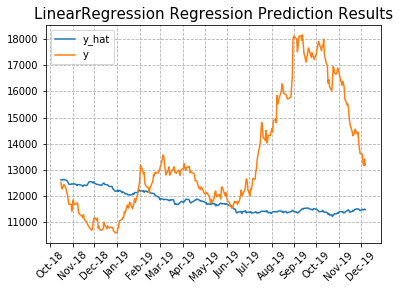


Polynomial MAE Results by Parameter Setting:
2 1265.1136827027678
3 1381.8860284394898
4 1639.9856870092333

Polynomial Minimum Test MAE:  1265.1136827027678
Polynomial Best Parameters:  2


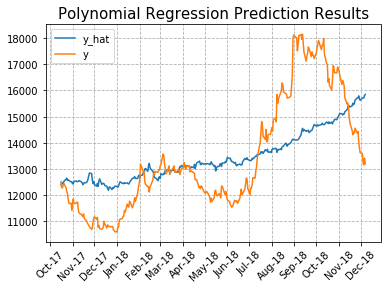


Lasso MAE Results by Parameter Setting:
{'alpha': 1e-05} 2175.105580476471
{'alpha': 0.0001} 2175.1055804449356
{'alpha': 0.001} 2175.1055801312123
{'alpha': 0.01} 2175.105577075356
{'alpha': 0.1} 2175.105546818765
{'alpha': 1} 2175.1052472473866

Lasso Minimum Test MAE:  2175.1052472473866
Lasso Best Parameters:  {'alpha': 1}


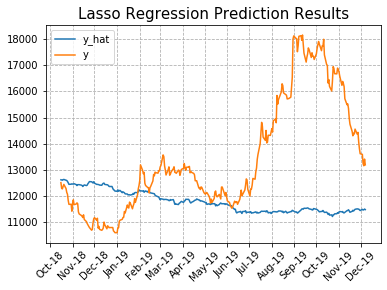


AdaBoostRegressor MAE Results by Parameter Setting:
{'learning_rate': 0.1, 'n_estimators': 50} 2592.9560066156932
{'learning_rate': 0.1, 'n_estimators': 100} 5105.069852078575
{'learning_rate': 0.1, 'n_estimators': 150} 6703.107760299901
{'learning_rate': 0.1, 'n_estimators': 200} 7902.341022716306
{'learning_rate': 0.1, 'n_estimators': 250} 8766.098920331267
{'learning_rate': 0.01, 'n_estimators': 50} 1661.1536439599229
{'learning_rate': 0.01, 'n_estimators': 100} 1903.1922955184875
{'learning_rate': 0.01, 'n_estimators': 150} 2109.0850069918138
{'learning_rate': 0.01, 'n_estimators': 200} 2283.136268621211
{'learning_rate': 0.01, 'n_estimators': 250} 2352.36556972466
{'learning_rate': 0.001, 'n_estimators': 50} 1587.160060259901
{'learning_rate': 0.001, 'n_estimators': 100} 1606.9583844854967
{'learning_rate': 0.001, 'n_estimators': 150} 1610.3870380642506
{'learning_rate': 0.001, 'n_estimators': 200} 1626.2166818607636
{'learning_rate': 0.001, 'n_estimators': 250} 1647.216535518840

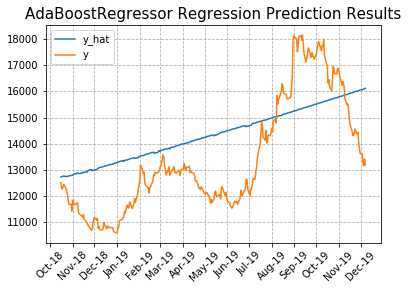


KNeighborsRegressor MAE Results by Parameter Setting:
1 2082.5986242845233
4 1292.0260365849624
7 1304.9255830160396
10 1196.8827420516232
13 1195.7021621421186
16 1188.3567353775425
19 1226.4356102803615
22 1297.2813748456658
25 1310.84700711441
28 1382.279112138002
31 1397.5587771301937
34 1372.3348680932559
37 1381.1119076389143
40 1375.937483927905
43 1375.952766831557
46 1381.9658468345385
49 1374.9374662581563
52 1371.4821912937578
55 1368.26042645664
58 1354.510480249382
61 1353.059368985342
64 1354.4911809800813

KNeighborsRegressor Minimum Test MAE:  1188.3567353775425
KNeighborsRegressor Best Parameters:  16


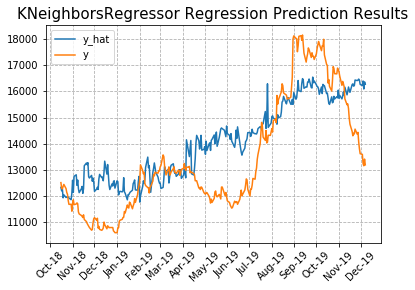


--------------------------------------------------------------------

One Day Ahead Predictions

Test Linear Regression MAE:  2023.1160930026872


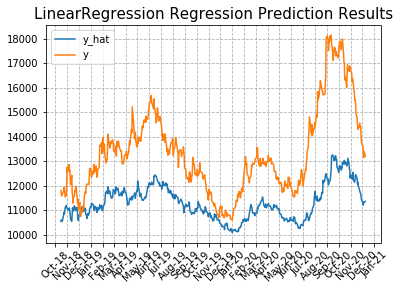


Polynomial MAE Results by Parameter Setting:
2 1403.79411127888
3 957.1912838497409
4 1051.7847431306818

Polynomial Minimum Test MAE:  957.1912838497409
Polynomial Best Parameters:  3


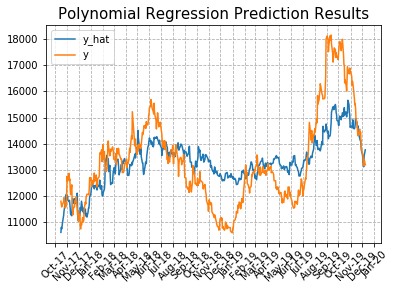


Lasso MAE Results by Parameter Setting:
{'alpha': 1e-05} 2023.1160930192016
{'alpha': 0.0001} 2023.1160931691104
{'alpha': 0.001} 2023.1160946711482
{'alpha': 0.01} 2023.1161096313156
{'alpha': 0.1} 2023.1162574555942
{'alpha': 1} 2023.1177128774539

Lasso Minimum Test MAE:  2023.1160930192016
Lasso Best Parameters:  {'alpha': 1e-05}


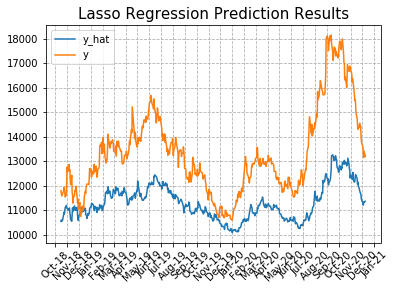


AdaBoostRegressor MAE Results by Parameter Setting:
{'learning_rate': 0.1, 'n_estimators': 50} 1437.3095430206604
{'learning_rate': 0.1, 'n_estimators': 100} 1750.9112141016349
{'learning_rate': 0.1, 'n_estimators': 150} 2577.041213308115
{'learning_rate': 0.1, 'n_estimators': 200} 3522.6039364513917
{'learning_rate': 0.1, 'n_estimators': 250} 4060.739854439227
{'learning_rate': 0.01, 'n_estimators': 50} 1667.4789828506462
{'learning_rate': 0.01, 'n_estimators': 100} 1308.953944686414
{'learning_rate': 0.01, 'n_estimators': 150} 1329.240029537733
{'learning_rate': 0.01, 'n_estimators': 200} 1404.4666178876153
{'learning_rate': 0.01, 'n_estimators': 250} 1378.1698115547802
{'learning_rate': 0.001, 'n_estimators': 50} 2014.8906833529945
{'learning_rate': 0.001, 'n_estimators': 100} 1863.7772044609028
{'learning_rate': 0.001, 'n_estimators': 150} 1784.9279871286647
{'learning_rate': 0.001, 'n_estimators': 200} 1789.5341504098685
{'learning_rate': 0.001, 'n_estimators': 250} 1814.30741176

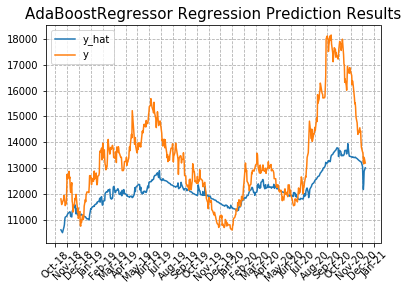


KNeighborsRegressor MAE Results by Parameter Setting:
1 1611.5347496360748
4 1833.4084900753937
7 1868.520012319429
10 1782.9274876356535
13 1696.547102292639
16 1740.7102386829426
19 1658.4805100865456
22 1600.4269534115617
25 1588.0929976143432
28 1520.7394721867197
31 1519.0501951983094
34 1521.0813821875188
37 1510.7283980671846
40 1499.6494770539375
43 1508.5002602162353
46 1488.1016661198178
49 1470.8860038005932
52 1443.5388411103827
55 1425.7834162265167
58 1416.26675613023
61 1404.402828300724
64 1398.8596923551984

KNeighborsRegressor Minimum Test MAE:  1398.8596923551984
KNeighborsRegressor Best Parameters:  64


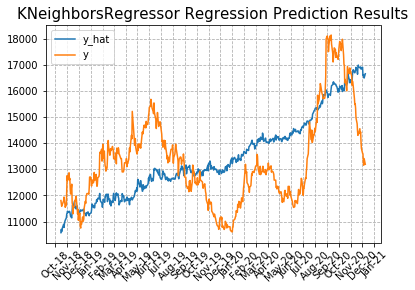

In [2]:

if __name__ == "__main__":
    window_setting= 5*4 # Rolling Average window setting for stationarity_preprocess function

    lag_length = 10 # lag length 2 weeks (5 business days)
    
    # Evaluations for one year ahead of time predictions compared to just one day ahead predictions (no time gap b/w X and y)

    for j,pred_type in enumerate(["One Year", "One Day"]):

        if j==0:    
            print(pred_type + " Ahead of Time Predictions")
            print()
            df, LME_shifted = preprocess_time_series(window_setting, lag_length)
            X_train, X_test, y_train, y_test = time_series_train_test_split(df)
            train_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        else:
            print()
            print('--------------------------------------------------------------------')
            print()
            print(pred_type + " Ahead Predictions")
            print()
            df, LME_shifted = preprocess_time_series_same_day(window_setting, lag_length)
            X_train, X_test, y_train, y_test = time_series_train_test_split_no_gap(df)
            #LME = LME_clean()    
            train_tail = LME_shifted.loc[y_train.index[-window_setting:]]


        mae = []
        parameter_setting = []
        model_name_list = []
        
        
        model_functions = [run_linear_reg,
                 run_polynomial,
                 run_lasso_grid,
                 run_adaboost_grid,
                 run_knn]


        for i in range(5):
            min_test_mae, min_parameters, model_name = model_functions[i](X_train, X_test, y_train, y_test, train_tail)
            mae.append(min_test_mae)
            parameter_setting.append(min_parameters)
            model_name_list.append(model_name)
       
        if j == 0:
            results = pd.DataFrame({'model_name': model_name_list, 'mae': mae, 'parameters': parameter_setting})
            results.to_csv('results/automodeling_mae.csv', index = False)